Make the necessary package imports:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing the necessary packages:

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import re

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Lambda
from sklearn.metrics import accuracy_score,precision_score,recall_score
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import random

In order to ensure results reproducibility, we set the random seeds for numpy, tensorflow and the python random package to a constant value of 42.

In [4]:
# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

We then made use of the python pandas library to read the data into memory:

In [5]:
training_df = pd.read_parquet("/content/drive/MyDrive/AdvancedML/relevance_train.parquet")

For relevance judgement, we consider the informative features about the article, and the user's query terms. Specifically we used the body and title features as representations of the article, and the topic_title and description features as representations of the user's query.

In [6]:
# visualization of the first 5 records
training_df.head()

,doc_id,judgement,author,body,byline,title,topic_id,description,narrative,topic_title
0,004c6120d0aa69da29cc045da0562168,0,Terrence McCoy,"<p>More than 60 years ago, a fair-skinned Iris...",By Terrence McCoy,Report on Irish baby homes documents use of in...,321,Pertinent documents will reflect the fact that...,Pertinent documents relating to this issue wil...,Women in Parliaments
1,005a1f0c2064487a7f15443b2a5f349a,0,Brian McNoldy,"<p>Hurricane Fred, which formed over the weeke...",By Brian McNoldy,Hurricane Fred is a fountain of ‘firsts’ in th...,321,Pertinent documents will reflect the fact that...,Pertinent documents relating to this issue wil...,Women in Parliaments
2,00722094-2935-11e2-b4e0-346287b7e56c,0,Editorial Board,"<p>EIGHT YEARS AGO this month, an inspiring mo...",By Editorial Board,Ukraine slides away from democracy,321,Pertinent documents will reflect the fact that...,Pertinent documents relating to this issue wil...,Women in Parliaments
3,007d2856-7cc4-11e4-84d4-7c896b90abdc,0,Adam Bernstein,"<p>Mary Burke Washington, an economist who was...",By Adam Bernstein,"Mary Washington, government official and widow...",321,Pertinent documents will reflect the fact that...,Pertinent documents relating to this issue wil...,Women in Parliaments
4,009aafb6-0283-11e6-8bb1-f124a43f84dc,0,None,"<p>When Treasury Secretary Jack Lew <a href=""h...",None,Will women be shortchanged again?,321,Pertinent documents will reflect the fact that...,Pertinent documents relating to this issue wil...,Women in Parliaments


Inspecting and visualizing the features to be used:
- Body and title: Representations of the newspaper article
- Topic title and Description: Representations of the user's query.

In [7]:
# description is a representation of what the user was actually searching for
training_df['description'][0]

'Pertinent documents will reflect the fact that women continue to be poorly represented in parliaments across the world, and the gap in political power between the sexes is very wide, particularly in the Third World.'

In [8]:
# topic title is a representation of what the user was actually searching for
training_df['topic_title'][0]

'Women in Parliaments'

In [9]:
#body is a representation of the actual contents of the article
training_df['body'][0]

'<p>More than 60 years ago, a fair-skinned Irish politician\xa0named Sally Mulready was born into a home for unwed mothers called St. Patrick’s. It sat on a road named\xa0Navan in Dublin, and Mulready\xa0was one of four siblings born there. Her brother John never made it out of St. Pat’s. Like hundreds of other babies born into an Irish\xa0homes for “fallen women,” John\xa0died in 1947. He was two months old.</p>\\n<p>“Inanition,” his death record read, <a href="http://www.rte.ie/news/primetime/2014/0609/622696-prime-time-anatomy-of-a-scandal/">according to RTE News</a>. “Failure to thrive.”</p>\\n<p>But RTE News <a href="http://www.rte.ie/news/primetime/2014/0609/622696-prime-time-anatomy-of-a-scandal/">said</a>\xa0the\xa0record carried a mystery. John for some reason wasn’t buried until 1950 — three years after his death. The oddity was first discarded as a clerical error.</p>\\n<p>But it wasn’t. John’s records had\xa0the designation “AS,” or\xa0“anatomical study.” His infant remains

In [10]:
# title is a representation of the actual contents of the article
training_df['title'][0]

'Report on Irish baby homes documents use of infants for med school cadavers, vaccine testing'

The above visualization shows how the title and body are accurate representations of the newspaper article, as well as how description and narrative are also accurate representations of the user's query. We now then proceed to create a subset of the dataset with these identified features only and use it to train the machine learning model.

In [11]:
# create a copy of the original dataset
training_df2 = training_df.copy()

In [12]:
# extract the useful representative features
training_df2 = training_df2.reindex(columns=['judgement','body','description','title','topic_title'])

The mathematical computations used by machine learning algorithms can not handle null values. We therefore searched the dataset for these values and replaced them with empty text.

In [13]:
training_df2.isna().sum()

judgement       0
body           69
description     0
title           0
topic_title     0
dtype: int64

Null values were identified in the body column. These are replaced with empty text - primarily because this column will be merged with the title column which doesn't have any null values. This ensures we still maintain an accurate representation of the overall newspaper article without losing any data.

In [14]:
# replace the null values with empty text
training_df2.fillna(' ',inplace=True)

Preprocess the text data: We now preprocess the text data in the identified informative fields. Specifically, we eliminate unnecessary html syntax from the data, remove unwanted backslashes, brackets and characters as shown in the function below:

In [15]:
# Preprocessing function
def preprocess_text(text):
  # remove html links, anchor tags and paragraph tags
  soup = BeautifulSoup(text,'html.parser')
  text = soup.get_text()

  text = text.lower()
  # remove unncessary backslashes
  text = re.sub(r'[^\w\s()/\\]', ' ',text)

  # remove unnecessary next line string tags
  text = text.replace('\\n', '')

  # the text has a consistent 'xa0' string - remove it too
  text = text.replace('\xa0', ' ')

  # tokenize - remove punctuations - remove stopwords - lemmatize
  tokens = word_tokenize(text)

  # remove punctuations
  tokens = [word for word in tokens if word not in string.punctuation]

  # remove stop words
  # Remove stop words
  stop_words = set(stopwords.words('english'))
  tokens = [word for word in tokens if word.lower() not in stop_words]

  lemmatizer = WordNetLemmatizer()
  tokens = [lemmatizer.lemmatize(word) for word in tokens]

  sentence = ' '.join(tokens)

  return sentence

We now apply the preprocessing function to the different columns of text:

In [16]:
training_df2['body'] = training_df2['body'].apply(preprocess_text)

In [17]:
training_df2['description'] = training_df2['description'].apply(preprocess_text)

<ipython-input-15-5f9a23e22177>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text,'html.parser')


In [18]:
training_df2['title'] = training_df2['title'].apply(preprocess_text)

<ipython-input-15-5f9a23e22177>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text,'html.parser')


In [19]:
training_df2['topic_title'] = training_df2['topic_title'].apply(preprocess_text)

Below is a visualization of some of the clean text in the preprocessed columns

In [20]:
training_df2['body'][0]

'60 year ago fair skinned irish politician named sally mulready born home unwed mother called st patrick sat road named navan dublin mulready one four sibling born brother john never made st pat like hundred baby born irish home fallen woman john died 1947 two month old inanition death record read according rte news failure thrive rte news said record carried mystery john reason buried 1950 three year death oddity first discarded clerical error john record designation anatomical study infant remains fact given researcher trinity college dublin used medical research though unclear whether mother given consent mulready eventually tracked burial plot explained irish time found marked stick number imagine happening child young baby died well family family influence happen baby beside john according recent irish government report confirming augmenting earlier report rte investigation called anatomy scandal report preliminary review designed set framework full formal investigation ordered ir

In [21]:
training_df2['description'][0]

'pertinent document reflect fact woman continue poorly represented parliament across world gap political power sex wide particularly third world'

In [22]:
training_df2['title'][0]

'report irish baby home document use infant med school cadaver vaccine testing'

In [23]:
training_df2['topic_title'][0]

'woman parliament'

We now shuffle the dataset and to increase its randomness and to also improve the model's learning capabilities:

In [24]:
training_df2 = shuffle(training_df2)

We then combine all the information about the newspaper article into one column called article - and all the information about a user's query into one column called query.

In [25]:
training_df2['article'] = training_df2['title'] + ' ' +training_df2['body']
training_df2['query'] = training_df2['topic_title'] + ' '+training_df2['description']

training_df2 = training_df2.reindex(columns=['judgement','article','query'])

Next, we create the training, validation and test sets

In [26]:
X,Y = training_df2[['article','query']],training_df2['judgement']

In [27]:
x_train_full,x_valid,y_train_full,y_valid = train_test_split(X,Y,test_size=0.015,random_state=42,stratify=Y)


In [28]:
x_train,x_test,y_train,y_test = train_test_split(x_train_full,y_train_full,test_size=0.015,random_state=42,stratify=y_train_full)

In [29]:
y_train_ = y_train.values
y_valid_ = y_valid.values
y_test_ = y_test.values

In [30]:
# visualize the shape of the training, validation and test sets
x_train.shape,x_valid.shape,x_test.shape

((19169, 2), (297, 2), (292, 2))

Tokenize the data:
- Because machine learning models can not process text in string format, we make use of the keras text vectorization layer to tokenize the input sentences and paragraphs and then transform these tokens to integer format.
- We chose the keras text vectorization layer primarily because it can be easily added to the model - hence making text preprocessing as part of our model and eliminating the unneccessary chunks of external text preprocessing code.
- We limit the number of tokens to 1000, and the length of the output sequence, for each sentence to 500. By setting the number of tokens to 1000, we restrict the vocabulary to 1000 words and each input sequence to 500 tokens. After multiple iterations and checks, this is a set of values that provided us with the best performance.
- We create two text vectorization layers because as will be described later, our model is built to compare user queries and the actual document - hence we tokenize and vectorize data about the document and user queries separately.

In [31]:
text_vec_layer_articles = tf.keras.layers.TextVectorization(max_tokens=1000,output_sequence_length=500)
text_vec_layer_queries = tf.keras.layers.TextVectorization(max_tokens=1000,output_sequence_length=500)

We partition our training data - into a part about the newspaper article and a part about the user query.

In [32]:
x_train_articles = list(x_train['article'].values)

We fit our text vectorization layers on the training set

In [33]:
text_vec_layer_articles.adapt(x_train_articles)

In [34]:
x_train_queries = list(x_train['query'].values)

In [35]:
text_vec_layer_queries.adapt(x_train_queries)

In [36]:
x_valid_queries = list(x_valid['query'].values)
x_valid_articles = list(x_valid['article'].values)
x_test_queries = list(x_test['query'].values)
x_test_articles = list(x_test['article'].values)

We make use of Stanford's pretrained GloVe embeddings - downloaded from the official site: https://nlp.stanford.edu/projects/glove/, to transform our sparse word representation vectors to dense vectors that are then later processed by our model. In order to effectively use these embeddings, we developed logic to map each word in our vocabulary to its representative embedding in the GloVe embeddings vector.

First, we map each word in our vocabulary to its representative integer index assigned to it by the tokenizer

In [37]:
articles_vocabulary = text_vec_layer_articles.get_vocabulary()
articles_wordindex = {word:index for index,word in enumerate(articles_vocabulary)}

In [38]:
queries_vocabulary = text_vec_layer_queries.get_vocabulary()
queries_wordindex = {word:index for index,word in enumerate(queries_vocabulary)}

Next, we load the pretrained embeddings and then map each word in our vocabulary to its embedding, then each word index from the tokenizer to its representative embedding. We made use of the 100-dimensional GloVe embeddings.

In [40]:
# load pretrained embeddings into memory
embeddings_index = dict()

In [42]:
with open('/content/drive/MyDrive/AdvancedML/glove.6B.100d.txt', 'r',encoding="utf8") as file:
    for line in file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:],dtype=np.float32)
        embeddings_index[word] = coefs

Mapping each tokenizer index integer to an embeddings vector. This ensures we create good starting weights for the 2 embedding layers - one embedding layer for the article content and one for the user queries content

In [43]:
articles_vocab_size = len(articles_wordindex)
articles_embedding_matrix = np.zeros((articles_vocab_size,100))

for word,i in articles_wordindex.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        articles_embedding_matrix[i] = embedding_vector

In [44]:
queries_vocab_size = len(queries_wordindex)
queries_embedding_matrix = np.zeros((queries_vocab_size,100))

for word,i in queries_wordindex.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        queries_embedding_matrix[i] = embedding_vector

Inspecting the shape of our weights vectors:

In [45]:
queries_embedding_matrix.shape,articles_embedding_matrix.shape

((300, 100), (1000, 100))

Complex Model:
- The model makes use of 2 embedding layers that make use of pretraiuned GloVe embeddings to compute embeddings for the articles and queries.
- The Euclidean distance between the article and query embeddings is then computed.
- The resultant vector is then fed into a series of LSTM layers.
- Finally we use a dense layer with the sigmoid activation to output the relevant class

In [46]:
# define a function to compute the Euclidean distance
def euclidean_distance(vectors):
	# unpack the vectors into separate lists
	(featsA, featsB) = vectors
	# compute the sum of squared distances between the vectors
	sumSquared = K.sum(K.square(featsA - featsB), axis=1,
		keepdims=True)
	# return the euclidean distance between the vectors
	return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [47]:
# define our 2 model inputs - article text and user query text
articles_input = tf.keras.layers.Input(shape=(),dtype=tf.string)
queries_input = tf.keras.layers.Input(shape=(),dtype=tf.string)

# tokenize and vectorize using the text vectorization layer
article_tokens = text_vec_layer_articles(articles_input)
query_tokens = text_vec_layer_queries(queries_input)

# compute embeddings using GloVe embeddings.
# set trainable to True to finetune the glove embeddings
articles_embedded = tf.keras.layers.Embedding(input_dim=articles_vocab_size,output_dim=100,
                             weights=[articles_embedding_matrix],trainable=True,mask_zero=True)(article_tokens)
queries_embedded = tf.keras.layers.Embedding(input_dim=queries_vocab_size,output_dim=100,
                                       weights=[queries_embedding_matrix],trainable=True,mask_zero=True)(query_tokens)

# compute the Euclidean distance between the 2 embedding vectors
distance=Lambda(euclidean_distance)([articles_embedded,queries_embedded])

# learn the relationship in the data using lstm cells
lstm1 = tf.keras.layers.LSTM(128,return_sequences=True,dropout=0.6)(distance)
lstm2 = tf.keras.layers.LSTM(64,dropout=0.4)(lstm1)

# add a single output layer
out = tf.keras.layers.Dense(1,activation="sigmoid")(lstm2)

model = tf.keras.Model(inputs=[articles_input,queries_input],outputs=[out])

In [48]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 text_vectorization (TextVe  (None, 500)                  0         ['input_1[0][0]']             
 ctorization)                                                                                     
                                                                                                  
 text_vectorization_1 (Text  (None, 500)                  0         ['input_2[0][0]']         

Convert the input data to appropriate tensorflow inputs:

In [49]:
x_train_articles = tf.constant(x_train_articles,dtype=tf.string)
x_train_queries = tf.constant(x_train_queries,dtype=tf.string)
x_valid_articles = tf.constant(x_valid_articles,dtype=tf.string)
x_valid_queries = tf.constant(x_valid_queries,dtype=tf.string)
x_test_queries = tf.constant(x_test_queries,dtype=tf.string)
x_test_articles = tf.constant(x_test_articles,dtype=tf.string)

In [50]:
precision = tf.keras.metrics.Precision()

In [51]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy',optimizer=opt,
              metrics=['accuracy',precision])

In [52]:
history = model.fit((x_train_articles,x_train_queries),y_train_,validation_data=((x_valid_articles,x_valid_queries),y_valid_),
                    epochs=60,batch_size=256)

Epoch 1/60
75/75 [==============================] - 17s 100ms/step - loss: 0.4582 - accuracy: 0.8366 - precision: 0.1990 - val_loss: 0.4375 - val_accuracy: 0.8418 - val_precision: 0.0000e+00
Epoch 2/60
75/75 [==============================] - 3s 42ms/step - loss: 0.4362 - accuracy: 0.8429 - precision: 0.0000e+00 - val_loss: 0.4376 - val_accuracy: 0.8418 - val_precision: 0.0000e+00
Epoch 3/60
75/75 [==============================] - 3s 38ms/step - loss: 0.4357 - accuracy: 0.8429 - precision: 0.0000e+00 - val_loss: 0.4395 - val_accuracy: 0.8418 - val_precision: 0.0000e+00
Epoch 4/60
75/75 [==============================] - 5s 66ms/step - loss: 0.4349 - accuracy: 0.8429 - precision: 0.0000e+00 - val_loss: 0.4355 - val_accuracy: 0.8418 - val_precision: 0.0000e+00
Epoch 5/60
75/75 [==============================] - 3s 36ms/step - loss: 0.4349 - accuracy: 0.8429 - precision: 0.0000e+00 - val_loss: 0.4361 - val_accuracy: 0.8418 - val_precision: 0.0000e+00
Epoch 6/60
75/75 [===================

Testing the model on the test set:

In [87]:
y_test_pred = model_bidirectional.predict((x_test_articles,x_test_queries))

10/10 [==============================] - 4s 12ms/step


Next, we determine the threshold that results in the best precision value:

In [88]:
precision, recall, thresholds = precision_recall_curve(y_test_, y_test_pred)

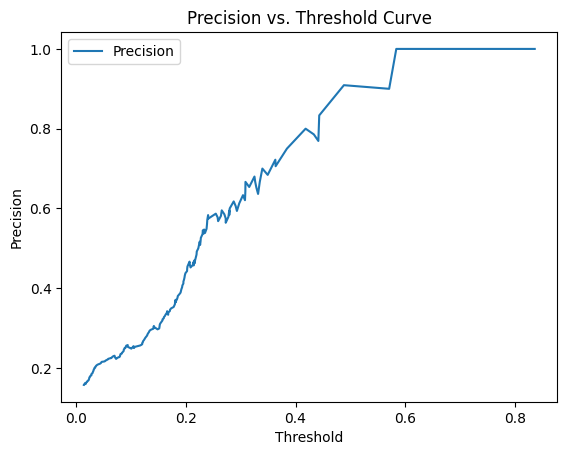

In [89]:
fig,ax = plt.subplots()
ax.plot(thresholds, precision[:-1], label='Precision')
ax.set_xlabel('Threshold')
ax.set_ylabel('Precision')
ax.set_title('Precision vs. Threshold Curve')
plt.legend()
plt.show()

In [90]:
# determine the maximum precision index
max_precision_index = np.argmax(precision[:-1])

# Get the threshold corresponding to the maximum precision
optimal_threshold = thresholds[max_precision_index]
optimal_threshold

0.5836487

In [91]:
# compute the test accuracy based on the optimal threshold
y_test_pred_ = (y_test_pred>=optimal_threshold).astype('int')
accuracy_score(y_test_,y_test_pred_)

0.8732876712328768

In [92]:
# compute the test set precision based on the optimal threshold
precision_score(y_test_,y_test_pred_)

1.0

Performance Charts:

Experiment: Changing the model's default LSTM cells to bidirectional LSTM cells and observing the performance changes:

In [61]:
articles_input = tf.keras.layers.Input(shape=(),dtype=tf.string)
queries_input = tf.keras.layers.Input(shape=(),dtype=tf.string)


article_tokens = text_vec_layer_articles(articles_input)
query_tokens = text_vec_layer_queries(queries_input)

articles_embedded = tf.keras.layers.Embedding(input_dim=articles_vocab_size,output_dim=100,
                             weights=[articles_embedding_matrix],trainable=True,mask_zero=True)(article_tokens)
queries_embedded = tf.keras.layers.Embedding(input_dim=queries_vocab_size,output_dim=100,
                                       weights=[queries_embedding_matrix],trainable=True,mask_zero=True)(query_tokens)

# concatenate the embeddings and remove the extra dimensions
distance=Lambda(euclidean_distance)([articles_embedded,queries_embedded])

# add an LSTM layer
lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,return_sequences=True,dropout=0.6))(distance)
lstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,dropout=0.4))(lstm1)

# add a single output layer
out = tf.keras.layers.Dense(1,activation="sigmoid")(lstm2)

model_bidirectional = tf.keras.Model(inputs=[articles_input,queries_input],outputs=[out])

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
precision_ = tf.keras.metrics.Precision()
model_bidirectional.compile(loss='binary_crossentropy',optimizer=opt,
              metrics=['accuracy',precision_])

history_bidirectional = model_bidirectional.fit((x_train_articles,x_train_queries),y_train_,validation_data=((x_valid_articles,x_valid_queries),y_valid_),
                    epochs=60,batch_size=256,verbose=0)

Experiment: Replacing LSTM cells with GRU cells

In [62]:
articles_input = tf.keras.layers.Input(shape=(),dtype=tf.string)
queries_input = tf.keras.layers.Input(shape=(),dtype=tf.string)


article_tokens = text_vec_layer_articles(articles_input)
query_tokens = text_vec_layer_queries(queries_input)

articles_embedded = tf.keras.layers.Embedding(input_dim=articles_vocab_size,output_dim=100,
                             weights=[articles_embedding_matrix],trainable=True,mask_zero=True)(article_tokens)
queries_embedded = tf.keras.layers.Embedding(input_dim=queries_vocab_size,output_dim=100,
                                       weights=[queries_embedding_matrix],trainable=True,mask_zero=True)(query_tokens)

# concatenate the embeddings and remove the extra dimensions
distance=Lambda(euclidean_distance)([articles_embedded,queries_embedded])

# add a GRU layer
gru1 = tf.keras.layers.GRU(128,return_sequences=True,dropout=0.6)(distance)
gru2 = tf.keras.layers.GRU(64,dropout=0.4)(gru1)

# add a single output layer
out = tf.keras.layers.Dense(1,activation="sigmoid")(gru2)

model_gru = tf.keras.Model(inputs=[articles_input,queries_input],outputs=[out])

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

precision__ = tf.keras.metrics.Precision()
model_gru.compile(loss='binary_crossentropy',optimizer=opt,
              metrics=['accuracy',precision__])

history_gru = model_gru.fit((x_train_articles,x_train_queries),y_train_,validation_data=((x_valid_articles,x_valid_queries),y_valid_),
                    epochs=60,batch_size=256,verbose=0)

Graphs to compare model performance and the 2 experiments:

Loss functions

In [69]:
train_loss = history.history['loss']
bidirectional_train_loss = history_bidirectional.history['loss']
gru_train_loss = history_gru.history['loss']

val_loss = history.history['val_loss']
bidirectional_val_loss = history_bidirectional.history['val_loss']
gru_val_loss = history_gru.history['val_loss']

epochs = range(1, len(train_loss) + 1)

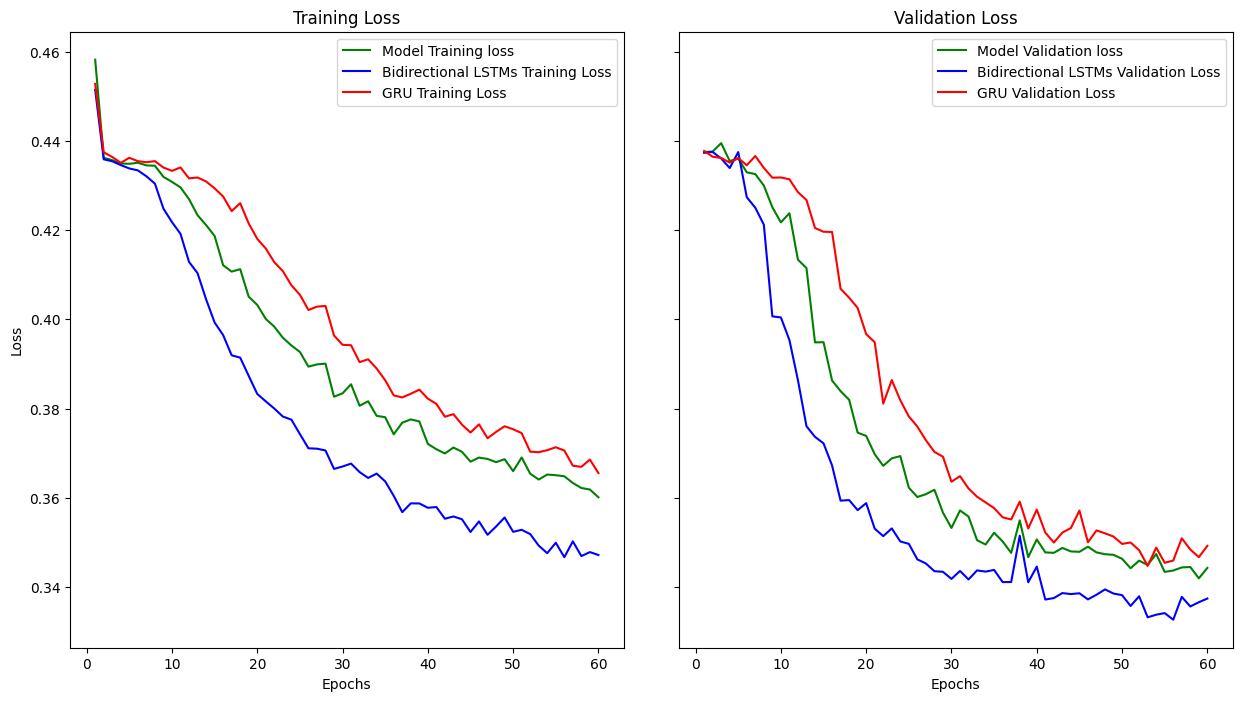

In [83]:
fig,ax=plt.subplots(1,2,figsize=(15,8),sharey=True)
plt.subplots_adjust(wspace=0.1)
ax[0].plot(epochs,train_loss,'g',label='Model Training loss')
ax[0].plot(epochs,bidirectional_train_loss,'b',label='Bidirectional LSTMs Training Loss')
ax[0].plot(epochs,gru_train_loss,'r',label='GRU Training Loss')
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(epochs,val_loss,'g',label='Model Validation loss')
ax[1].plot(epochs,bidirectional_val_loss,'b',label='Bidirectional LSTMs Validation Loss')
ax[1].plot(epochs,gru_val_loss,'r',label='GRU Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_title('Validation Loss')
ax[1].legend()


Precision:

In [81]:
train_precision = history.history['precision']
bidirectional_train_precision = history_bidirectional.history['precision_1']
gru_train_precision = history_gru.history['precision_2']

val_precision = history.history['val_precision']
bidirectional_val_precision = history_bidirectional.history['val_precision_1']
gru_val_precision = history_gru.history['val_precision_2']

epochs = range(1, len(train_loss) + 1)

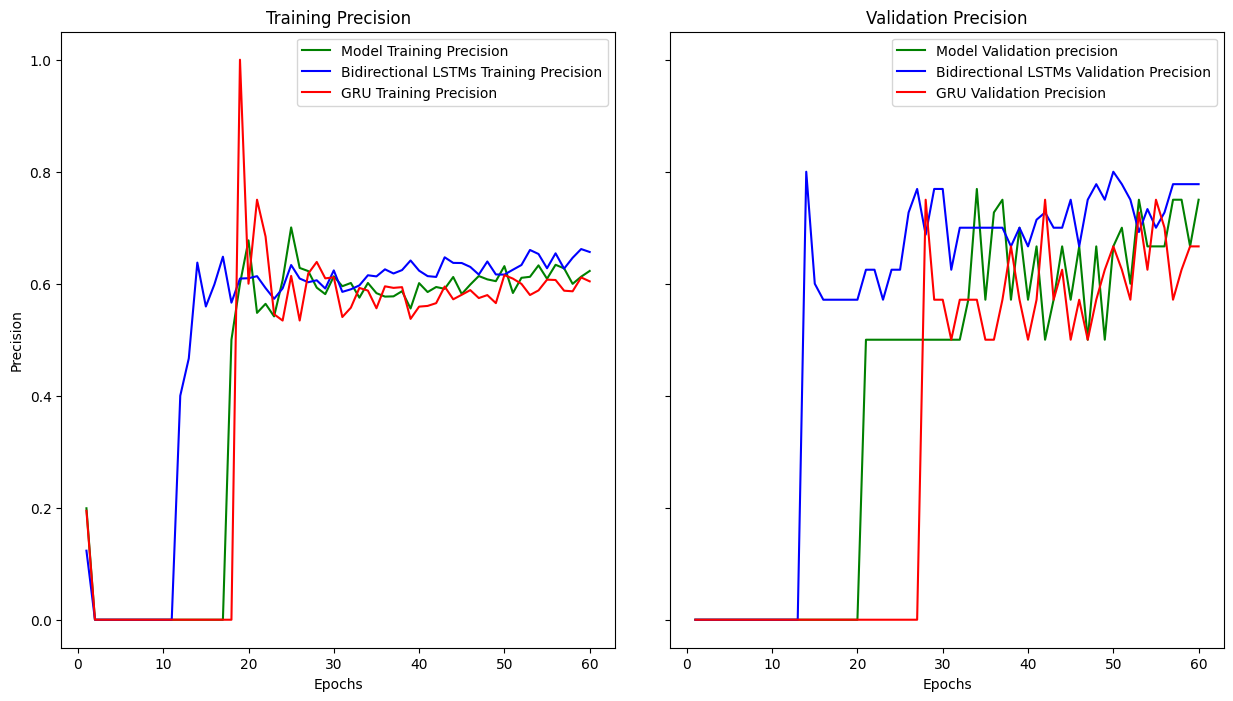

In [84]:
fig,ax=plt.subplots(1,2,figsize=(15,8),sharey=True)
plt.subplots_adjust(wspace=0.1)
ax[0].plot(epochs,train_precision,'g',label='Model Training Precision')
ax[0].plot(epochs,bidirectional_train_precision,'b',label='Bidirectional LSTMs Training Precision')
ax[0].plot(epochs,gru_train_precision,'r',label='GRU Training Precision')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Precision')
ax[0].set_title('Training Precision')
ax[0].legend()

ax[1].plot(epochs,val_precision,'g',label='Model Validation precision')
ax[1].plot(epochs,bidirectional_val_precision,'b',label='Bidirectional LSTMs Validation Precision')
ax[1].plot(epochs,gru_val_precision,'r',label='GRU Validation Precision')
ax[1].set_xlabel('Epochs')
ax[1].set_title('Validation Precision')
ax[1].legend()

Accuracy:

In [85]:
train_accuracy = history.history['accuracy']
bidirectional_train_accuracy = history_bidirectional.history['accuracy']
gru_train_accuracy = history_gru.history['accuracy']

val_accuracy = history.history['val_accuracy']
bidirectional_val_accuracy = history_bidirectional.history['val_accuracy']
gru_val_accuracy = history_gru.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

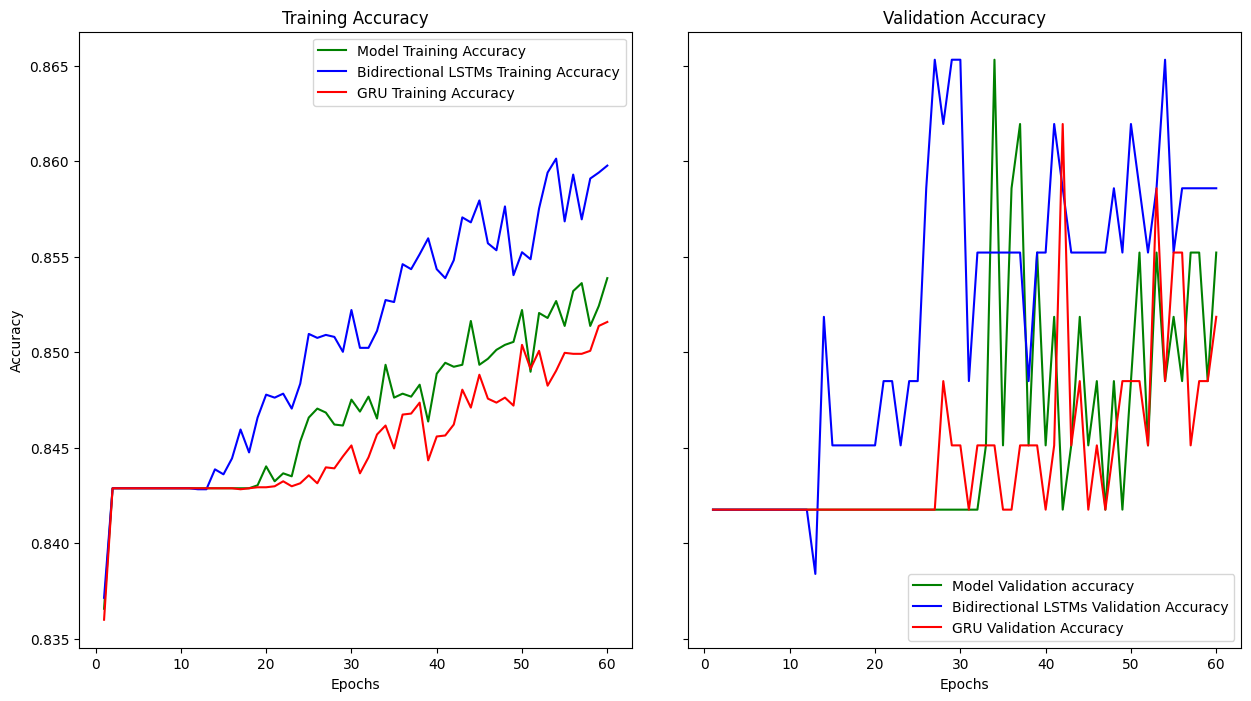

In [86]:
fig,ax=plt.subplots(1,2,figsize=(15,8),sharey=True)
plt.subplots_adjust(wspace=0.1)
ax[0].plot(epochs,train_accuracy,'g',label='Model Training Accuracy')
ax[0].plot(epochs,bidirectional_train_accuracy,'b',label='Bidirectional LSTMs Training Accuracy')
ax[0].plot(epochs,gru_train_accuracy,'r',label='GRU Training Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Training Accuracy')
ax[0].legend()

ax[1].plot(epochs,val_accuracy,'g',label='Model Validation accuracy')
ax[1].plot(epochs,bidirectional_val_accuracy,'b',label='Bidirectional LSTMs Validation Accuracy')
ax[1].plot(epochs,gru_val_accuracy,'r',label='GRU Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_title('Validation Accuracy')
ax[1].legend()

Much as the bidirectional LSTM seemed to have better performance (accuracy, precision and loss) than the default model and the GRU model. Both the model with GRUs and the default model outperformed the Bidirectional LSTM model on the Kaggle dataset - achieving a score 0f 0.87305 compared to the bidirectional LSTM score of 0.87278

Predicting on the test set and uploading to kaggle:

In [94]:
test_df = pd.read_parquet("/content/drive/MyDrive/AdvancedML/relevance_test.parquet")

In [95]:
test_df2 = test_df.copy()

In [96]:
test_df2 = test_df2.reindex(columns=['body','description','title','topic_title'])

In [97]:
test_df2.fillna(' ',inplace=True)

In [98]:
test_df2['body'] = test_df2['body'].apply(preprocess_text)

In [99]:
test_df2['description'] = test_df2['description'].apply(preprocess_text)

In [100]:
test_df2['title'] = test_df2['title'].apply(preprocess_text)

<ipython-input-15-5f9a23e22177>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text,'html.parser')


In [101]:
test_df2['topic_title'] = test_df2['topic_title'].apply(preprocess_text)

In [102]:
test_df2['article'] = test_df2['title'] + ' ' +test_df2['body']
test_df2['query'] = test_df2['topic_title'] + ' '+test_df2['description']

test_df2 = test_df2.reindex(columns=['article','query'])

In [103]:
test_articles = tf.constant(list(test_df2['article'].values),dtype=tf.string)
test_query = tf.constant(list(test_df2['query'].values),dtype=tf.string)

In [104]:
predz = model_bidirectional.predict((test_articles,test_query))

153/153 [==============================] - 2s 11ms/step


In [105]:
optimal_threshold

0.5836487

In [106]:
test_df['judgement'] = (predz>optimal_threshold).astype('int')

In [107]:
test_df = test_df.reindex(columns=['doc_id','judgement'])

In [108]:
test_df.rename(columns={'doc_id': 'id'}, inplace=True)

In [109]:
file_path = 'output.csv'

# Write the DataFrame to a CSV file
test_df.to_csv(file_path, index=False)